<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для интернет-магазина с BERT

Интернет-магазин запускает новый сервис: пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах, то есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Описание данных:** набор данных (текстов комментариев) с разметкой о токсичности правок.

**Задача**: обучить модель для классификации комментарии на позитивные и негативные. 


**Этапы:**

1. Загрузка и подготовка данных.
2. Обучение разных моделей. 
3. Выводы.

## Подготовка

In [1]:
!pip install wordcloud -q # подключаем библиотеку для создания облака слов
!pip install --upgrade pip
!pip install --upgrade pillow

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
import numpy as np
import pandas as pd
import torch
import transformers
import seaborn as sns

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

import nltk
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt') # делит текст на список предложений
from sklearn.feature_extraction.text import CountVectorizer #преобразователь корпуса текстов в мешок слов
from nltk.corpus import stopwords
nltk.download("stopwords") # поддерживает удаление стоп-слов

from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# загрузка данных
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# общая информация о данных
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Text(0, 0.5, 'Количество')

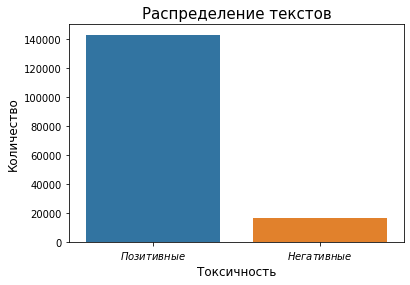

In [5]:
# визуализация содержания комментариев
sns.countplot(data=toxic_comments, x="toxic")
plt.title ('Распределение текстов', fontsize=15)
plt.xticks(np.linspace(0, 1, 2),  # место отметки
           (r'$Позитивные$', r'$Негативные$'))
plt.xlabel ('Токсичность', fontsize=12)
plt.ylabel ('Количество', fontsize=12)

Очистка текста

In [6]:
# функция для очистки текста
def clear_text(text):
    text=text.lower()
    return " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())

In [7]:
# очищенный текст
toxic_comments['text_lemm'] = toxic_comments['text'].apply(clear_text)
toxic_comments.head()

,text,toxic,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


Лемматизация текстов:

In [8]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [9]:
%%time
toxic_comments['text_lemm'] = toxic_comments['text_lemm'].apply(lemmatize_text)

CPU times: user 44.1 s, sys: 673 ms, total: 44.8 s
Wall time: 45.1 s


In [10]:
toxic_comments.head()

,text,toxic,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,0,"[d, aww, he, match, this, background, colour, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, i, m, really, not, trying, to, edit..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[more, i, can, t, make, any, real, suggestion,..."
4,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re..."


Очистка от стоп-слов.

In [11]:
stop_words = set(stopwords.words('english'))
def no_stopwords(text):
    return [word for word in text if word.lower() not in stop_words]

In [12]:
toxic_comments['text_lemm'] = toxic_comments['text_lemm'].apply(no_stopwords)

In [13]:
def join_words(text):
    return " ".join(text)
toxic_comments['text_lemm_clear'] = toxic_comments['text_lemm'].apply(join_words)
toxic_comments.head()

,text,toxic,text_lemm,text_lemm_clear
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,...",explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,"[aww, match, background, colour, seemingly, st...",aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, really, trying, edit, war, guy, con...",hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,"[make, real, suggestion, improvement, wondered...",make real suggestion improvement wondered sect...
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page]",sir hero chance remember page


Визуализируем частотность слов

In [14]:
# разделим на токены
%time
tokens = word_tokenize(' '.join(toxic_comments['text_lemm_clear']))
text = nltk.Text(tokens)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [15]:
text_raw = ' '.join(text)

In [16]:
# генерация облака слов
wordcloud = WordCloud().generate(text_raw)

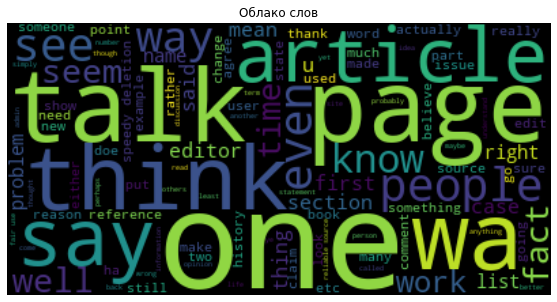

In [17]:
# визуализация слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов')
plt.show()

In [18]:
toxic_comments_0 = toxic_comments.where(toxic_comments['toxic']==0)
print ('Количество позитивных коментариев:', toxic_comments_0.shape[0])

Количество позитивных коментариев: 159292


In [19]:
toxic_comments_1 = toxic_comments[toxic_comments['toxic']==1]
print ('Количество негативных коментариев:', toxic_comments_1.shape[0])

Количество негативных коментариев: 16186


Для дальнейшего анализа отберем случайным образом 400 комментариев.

In [20]:
toxic_comments_400 = toxic_comments.sample(400, random_state=5, replace = False)
toxic_comments_400['toxic'].value_counts()

0    356
1     44
Name: toxic, dtype: int64

In [21]:
toxic_comments_400 = toxic_comments_400.dropna()
toxic_comments_400.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 27036 to 83385
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             400 non-null    object
 1   toxic            400 non-null    int64 
 2   text_lemm        400 non-null    object
 3   text_lemm_clear  400 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.6+ KB


Разделим данные на обучающую и тестовую выборки:

In [22]:
X_train, X_test, y_train, y_test = train_test_split (
    toxic_comments_400['text_lemm_clear'], toxic_comments_400['toxic'], test_size = 0.25,
    random_state=0, stratify = toxic_comments_400['toxic'])

Количество негативных комментариев в несколько раз меньше позитивных. Для более точного прогнозирования увеличим их количество в обучающей выборке.

In [23]:
y_train.value_counts()

0    267
1     33
Name: toxic, dtype: int64

Добавим из исходной выборки дополнительно в обучающую 100 комментарием со значением в столбце 'toxic' = 1. Для избежания утечки данных удалим строки из тестовой выборки.

In [24]:
extra = toxic_comments_1[~toxic_comments_1.index.isin(list(toxic_comments_400.index))]
extra_100 = extra.sample(100, random_state=5, replace = False)

In [25]:
X_train = pd.concat([X_train, extra_100['text_lemm_clear']])
y_train = pd.concat([y_train, extra_100['toxic']])

In [26]:
print ('Размер обучающей выборки:', X_train.shape)
print ('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (400,)
Размер тестовой выборки: (100,)


In [27]:
X_train.head()

25599                                          payback get
88572    version according version audio bully bang ban...
88971    bishonen wrong provides evidence little bit po...
99570    bnp ha history anti semitism ha bnp member jew...
77850    horrid little shit monitoring editing pattern ...
Name: text_lemm_clear, dtype: object

In [28]:
print ('Распределение целевого признака в обучающей выборке:', '\n', y_train.value_counts())
print ('Распределение целевого признака в тестовой выборке:', '\n', y_test.value_counts())

Распределение целевого признака в обучающей выборке: 
 0    267
1    133
Name: toxic, dtype: int64
Распределение целевого признака в тестовой выборке: 
 0    89
1    11
Name: toxic, dtype: int64


In [29]:
tokenizer = transformers.AutoTokenizer.from_pretrained("unitary/toxic-bert")
# трансформируем обучающую выборку:
tokenized_tr = X_train.apply(lambda x: tokenizer.encode(str(x), add_special_tokens=True, truncation=True, max_length=260))
max_len = 0
for i in tokenized_tr.values:
    if len(i) > max_len:
        max_len = len(i)

padded_tr = np.array([i + [0]*(max_len - len(i)) for i in tokenized_tr.values])

attention_mask_tr = np.where(padded_tr != 0, 1, 0)

In [30]:
padded_tr.shape

(400, 260)

In [31]:
# трансформируем тестовую выборку:
tokenized_test = X_test.apply(lambda x: tokenizer.encode(str(x), add_special_tokens=True, truncation=True, max_length=260))
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)

padded_test = np.array([i + [0]*(max_len - len(i)) for i in tokenized_test.values])
attention_mask_test = np.where(padded_test != 0, 1, 0)
padded_test.shape

(100, 260)

In [32]:
# инициализируем модель
model = transformers.AutoModel.from_pretrained("unitary/toxic-bert")

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
# для ускорения расчетов воспользуемся графическим процессором.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
batch_size = 50
embeddings_tr = []
for i in notebook.tqdm(range(padded_tr.shape[0] // batch_size)):
        batch = torch.LongTensor(padded_tr[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_tr[batch_size*i:batch_size*(i+1)]).to(device)
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        embeddings_tr.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
# эмбединги для тестовой выборки 
embeddings_test = []
for i in notebook.tqdm(range(padded_test.shape[0] // batch_size)):
        batch = torch.LongTensor(padded_test[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask_test[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings_test.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/2 [00:00<?, ?it/s]

In [36]:
# признаки тренировочной выборки 
features_train = np.concatenate(embeddings_tr)
features_train.shape

(400, 768)

In [37]:
# признаки тестовой выборки 
features_test = np.concatenate(embeddings_test)
features_test.shape

(100, 768)

## Обучение

Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC() и выберем лучшую модель.

In [38]:
RANDOM_STATE = 42
pipe_final = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 16),
        'models__max_features': range(2, 16)  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 16),
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5)
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel = 'poly')]
    }
]

In [39]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(features_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# прогноз на тестовых данных
y_test_pred = randomized_search.predict(features_test)
# проверка модели на тестовой выборке
print(f'F1-мера: {f1_score(y_test, y_test_pred)}');

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Лучшая модель и её параметры:

 Pipeline(steps=[('models', KNeighborsClassifier(n_neighbors=6))])
Метрика лучшей модели на тренировочной выборке: 0.9411409544950056
F1-мера: 0.7692307692307693


## Выводы

Исходные комментарии в количестве 159292 обработаны моделью BERT. Для обучения и подбора лучшей модели отобраны случайным образом 500 строк, в том числе 400 включены в тренировочную выборку, а 100 - в тестовую. На отобранных данных проведено обучение 4 разных моделей машинного обучения с разными параметрами, в результате которого лучший результат по метрике точности f1 показала модель 6 ближайших соседей (f1-мера на тренировочной выборке показала результат, равный 0.94, а на тестовой - 0.77).